# MLP

Split data into Train , val, test

In [1]:
from typing import List

In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn.functional as F

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## 2. Data Pre-Processing

In [6]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [7]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [8]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [9]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Small Data

In [10]:
# TEST DATASET
X, Y = get_ngrams(words=words[:4], ngrams=NGRAMS, debug=True)

-- emma --
... e
..e m
.em m
emm a
mma .
-- olivia --
... o
..o l
.ol i
oli v
liv i
ivi a
via .
-- ava --
... a
..a v
.av a
ava .
-- isabella --
... i
..i s
.is a
isa b
sab e
abe l
bel l
ell a
lla .


In [11]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0]))

#### 2.1.2 Train Test split

In [12]:
# Split to 80 : 10 : 10 :: Train : Val : Test

def split_data(data: List, ratio: float = 0.8):
    split_idx = int(ratio*len(data))
    return data[:split_idx], data[split_idx:]

split_data(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

([1, 2, 3, 4, 5, 6, 7, 8], [9, 0])

In [13]:
import random

# Shuffle words
random.shuffle(words)

In [14]:
train_words, test_words = split_data(data=words, ratio=0.8)
val_words, test_words = split_data(data=test_words, ratio=0.5)

len(train_words), len(val_words), len(test_words)

(25626, 3203, 3204)

In [15]:
# Complete Dataset

X_train, Y_train = get_ngrams(words=train_words, ngrams=NGRAMS, debug=False)
X_val, Y_val = get_ngrams(words=val_words, ngrams=NGRAMS, debug=False)
X_test, Y_test = get_ngrams(words=test_words, ngrams=NGRAMS, debug=False)


X_train.shape, Y_train.shape

(torch.Size([182372, 3]), torch.Size([182372]))

## 3. MLP

### 3.1 Architecture
From paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

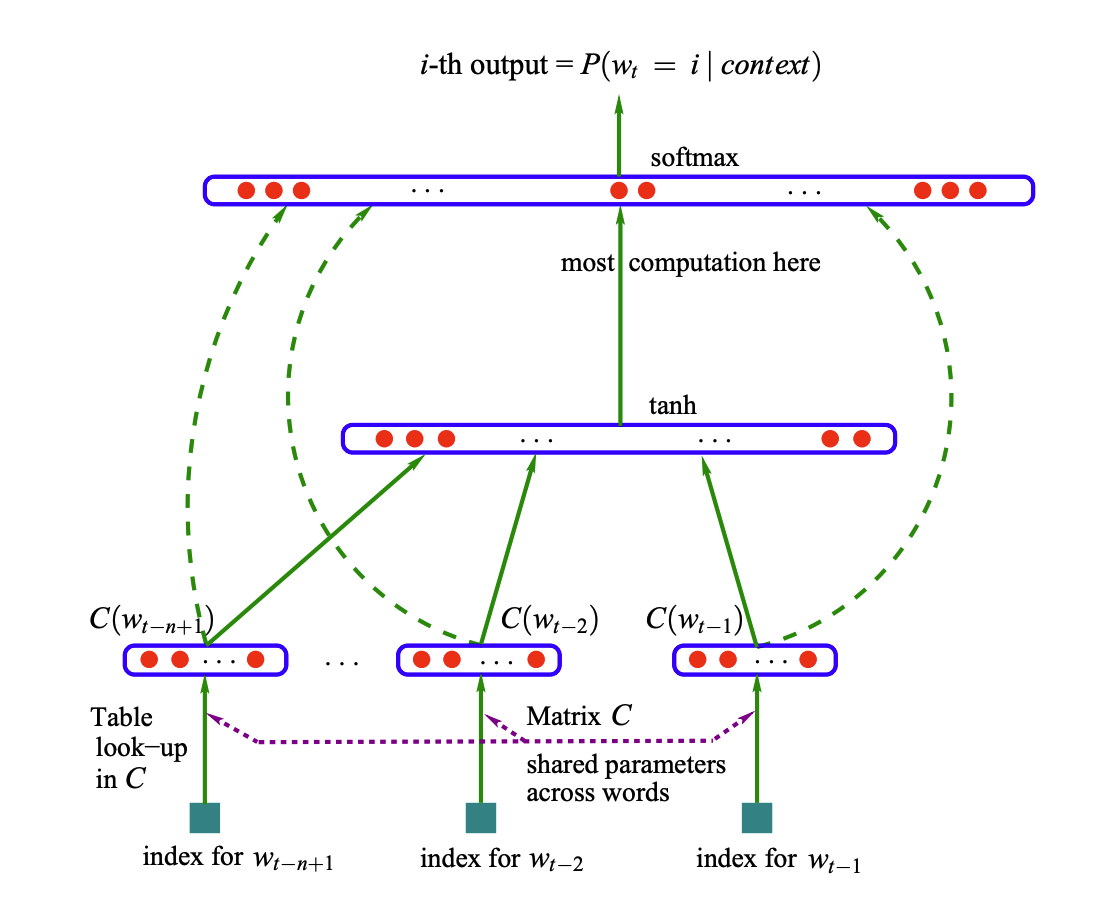

In [16]:
class MLP:
    
    def __init__(self, n_in, n_embed, n_positions, seed=4744):
        
        # Seed for reproducibility
        g = torch.Generator().manual_seed(seed)

        # Embeding Layer
        self.C = torch.randn((n_in, n_embed), generator=g)    

        # Hidden Layer
        self.W1 = torch.randn((CONTEXT_SIZE * n_embed, n_positions), generator=g)
        self.b1 = torch.randn((n_positions), generator=g)

        # Output Layer
        self.W2 = torch.randn((n_positions, n_in), generator=g)
        self.b2 = torch.randn((n_in), generator=g)

        # Parameters
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        print(f"Number of Model Params: {sum(p.nelement() for p in self.parameters)}")

        # Require Grads , for backprop
        for p in self.parameters: p.requires_grad = True
        
    def __call__(self, x):
        
        # Forward call
        emb = self.C[x]                                       # C(CHARS, N_EMBEDS) X[N, CONTEXT_SIZE] --> emb(N, CONTEXT_SIZE, N_EMBEDS)
        h = emb.view(emb.shape[0], -1) @ self.W1 + self.b1    # emb.view(N, CONTEXT_SIZE*N_EMBEDS) @ W1 + b1 --> (N, N_POSITIONS)
        logits = h @ self.W2 + self.b2                        # --> logits(N, CHARS)
        return logits
  

### 3.2 Training Loop

In [17]:
class Trainer:
    
    def __init__(self, model):
        self.model = model
        self.get_batch_idxs = lambda x: torch.randint(0, x.shape[0], size=(BATCH_SIZE,))
        self.losses = list()
        
    def train(self, x, y, batch_size=32, epochs=10, lr=0.1):
        print(f"Dataset size: {len(x)}")

        for epoch in tqdm(range(epochs), desc="Epochs"):

            # Batch indexes
            ix = self.get_batch_idxs(x)
            _x = x[ix]
            _y = y[ix]

            # Forward
            logits = self.model(_x)
            loss = F.cross_entropy(logits, _y)
            if epoch in {0} or epoch % int(epochs/10) == int(epochs/10) - 1: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
            self.losses.append(loss.item())

            # Backward
            for p in model.parameters: p.grad = None
            loss.backward()

            # Optimizer
            for p in model.parameters: p.data -= lr * p.grad
            
        return self.losses
    
    def evaluate(self, x, y):
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        return loss

#### 3.6.1 Training

In [18]:
N_EMBED = 2 
N_POSITIONS = 300

BATCH_SIZE = 32
EPOCHS = 1000
LR = 0.1

In [19]:
# INIT MODEL
model = MLP(n_in=len(CHARS), n_embed=N_EMBED, n_positions=N_POSITIONS)

Number of Model Params: 10281


In [20]:
trainer = Trainer(model=model)

Dataset size: 182372


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss 1/1000: 97.38606262207031
Loss 100/1000: 20.819602966308594
Loss 200/1000: 8.680789947509766
Loss 300/1000: 6.867917060852051
Loss 400/1000: 4.985699653625488
Loss 500/1000: 7.212890148162842
Loss 600/1000: 3.6396069526672363
Loss 700/1000: 5.897127628326416
Loss 800/1000: 4.465834140777588
Loss 900/1000: 3.7067837715148926
Loss 1000/1000: 4.381627559661865


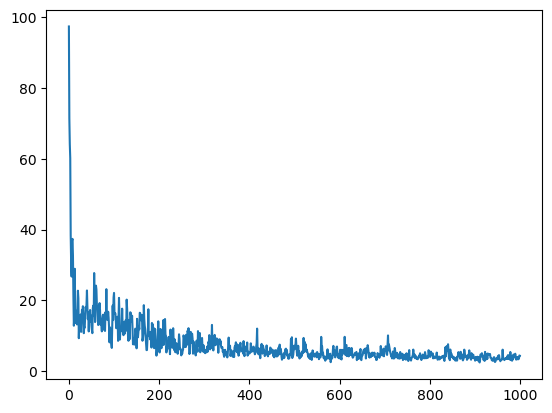

In [21]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1000, lr=0.1)
plt.plot(losses)

In [22]:
# Train Loss
trainer.evaluate(x=X_train, y=Y_train)

tensor(3.7296, grad_fn=<NllLossBackward0>)

In [23]:
# Val Loss
trainer.evaluate(x=X_val, y=Y_val)

tensor(3.7282, grad_fn=<NllLossBackward0>)

#### 3.6.2 lr Decay

In [24]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=100, lr=0.05)

Dataset size: 182372


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Loss 1/100: 3.938100576400757
Loss 10/100: 2.423302173614502
Loss 20/100: 2.492502450942993
Loss 30/100: 2.3374011516571045
Loss 40/100: 3.023705244064331
Loss 50/100: 3.0939526557922363
Loss 60/100: 2.2797489166259766
Loss 70/100: 2.5761868953704834
Loss 80/100: 2.7376868724823
Loss 90/100: 2.4922168254852295
Loss 100/100: 2.589144706726074


In [25]:
# Val Loss
trainer.evaluate(x=X_val, y=Y_val)

tensor(2.6385, grad_fn=<NllLossBackward0>)

### 3.3 Visualizing Embeddings 

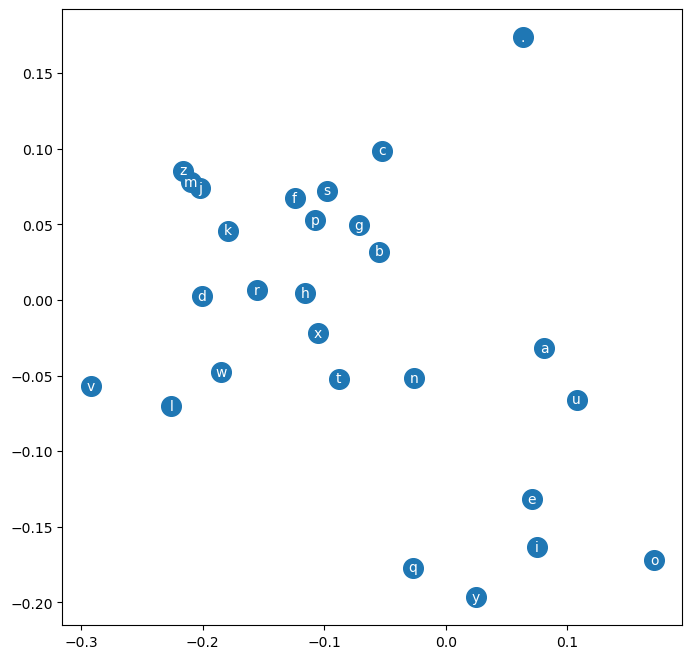

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(model.C[:, 0].data, model.C[:, 1].data, s=200)
for i in range(model.C.shape[0]):
    plt.text(model.C[i,0].item(), model.C[i, 1].item(), itos[i], ha="center", va="center", color="white")